In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os

### Configure Paths

In [ ]:
# raw dataset
data_root = '../../DATASET_01/DATASET_01/'

# Output path 
output_path = './'

# Target noise level for benchmark comparison
target_noise_level = 0.7

# Data name for consistent file naming across notebooks
dataName = 'dataset01'

### Load All Images

In [ ]:
clean_image = imread(data_root + 'clean_image.tif')
print(f"Clean image shape: {clean_image.shape}")
print(f"Clean image dtype: {clean_image.dtype}")
print(f"Clean image range: [{clean_image.min():.4f}, {clean_image.max():.4f}]")


jittered_image = imread(data_root + 'jittered_image.tif')
print(f"\nJittered image shape: {jittered_image.shape}")
print(f"Jittered image dtype: {jittered_image.dtype}")
print(f"Jittered image range: [{jittered_image.min():.4f}, {jittered_image.max():.4f}]")

Clean image shape: (128, 128)
Clean image dtype: uint8
Clean image range: [0.0000, 255.0000]

Jittered image shape: (128, 128)
Jittered image dtype: uint8
Jittered image range: [0.0000, 254.0000]


In [ ]:
noisy_path = data_root + f'Noisy images/noisy_image_jitter_skips_0__0_3_flags_0__0_4_Gaussian_{target_noise_level}.tif'
noisy_image = imread(noisy_path)

print(f"Noisy image (σ={target_noise_level}) shape: {noisy_image.shape}")
print(f"Noisy image dtype: {noisy_image.dtype}")
print(f"Noisy image range: [{noisy_image.min():.4f}, {noisy_image.max():.4f}]")

Noisy image (σ=0.7) shape: (128, 128)
Noisy image dtype: uint8
Noisy image range: [0.0000, 255.0000]


### Visualize the Three Key Images

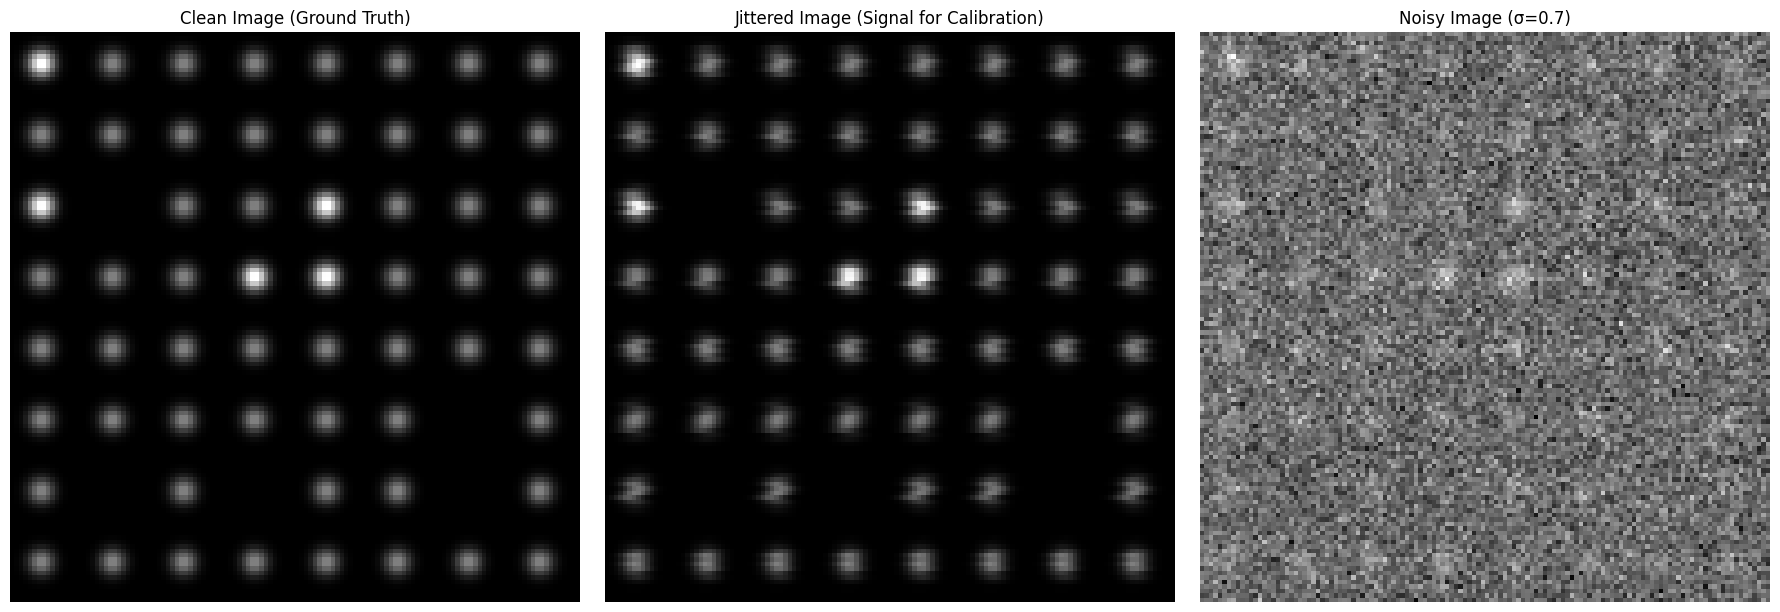


Baseline Quality (Noisy vs Clean):
  PSNR: 7.95 dB
  SSIM: 0.0742

Supervisor's Benchmark to Beat:
  PSNR: 28.48 dB
  SSIM: 0.73


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(clean_image, cmap='gray')
axes[0].set_title('Clean Image (Ground Truth)')
axes[0].axis('off')

axes[1].imshow(jittered_image, cmap='gray')
axes[1].set_title('Jittered Image (Signal for Calibration)')
axes[1].axis('off')

axes[2].imshow(noisy_image, cmap='gray')
axes[2].set_title(f'Noisy Image (σ={target_noise_level})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Calculate baseline metrics (noisy vs clean)
# Normalize for PSNR/SSIM calculation if needed
clean_norm = (clean_image - clean_image.min()) / (clean_image.max() - clean_image.min())
noisy_norm = (noisy_image - noisy_image.min()) / (noisy_image.max() - noisy_image.min())

baseline_psnr = psnr(clean_norm, noisy_norm, data_range=1.0)
baseline_ssim = ssim(clean_norm, noisy_norm, data_range=1.0)

print(f"\nBaseline Quality (Noisy vs Clean):")
print(f"  PSNR: {baseline_psnr:.2f} dB")
print(f"  SSIM: {baseline_ssim:.4f}")
print(f"\nSupervisor's Benchmark to Beat:")
print(f"  PSNR: 28.48 dB")
print(f"  SSIM: 0.73")

### Prepare Data for PN2V Pipeline

Convert images to float32 and save in a format suitable for the pipeline.

In [9]:
# Convert to float32
clean_f32 = clean_image.astype(np.float32)
jittered_f32 = jittered_image.astype(np.float32)
noisy_f32 = noisy_image.astype(np.float32)

# For PN2V training, we need the noisy image as a stack (even if single image)
# This allows the training code to work with its expected format
noisy_stack = noisy_f32[np.newaxis, ...]  # Shape: (1, H, W)

print(f"Noisy stack shape for training: {noisy_stack.shape}")

Noisy stack shape for training: (1, 128, 128)


In [10]:
# Save prepared data
imwrite(output_path + f'{dataName}_clean.tif', clean_f32)
imwrite(output_path + f'{dataName}_signal.tif', jittered_f32)  # Signal for calibration
imwrite(output_path + f'{dataName}_noisy.tif', noisy_stack)    # Observation for calibration & training

print("Saved files:")
print(f"  - {dataName}_clean.tif   (Ground truth for evaluation)")
print(f"  - {dataName}_signal.tif  (Signal for noise model calibration)")
print(f"  - {dataName}_noisy.tif   (Noisy observation for calibration & training)")

Saved files:
  - dataset01_clean.tif   (Ground truth for evaluation)
  - dataset01_signal.tif  (Signal for noise model calibration)
  - dataset01_noisy.tif   (Noisy observation for calibration & training)


### Zoom Comparison

Visualize a cropped region to see noise detail.

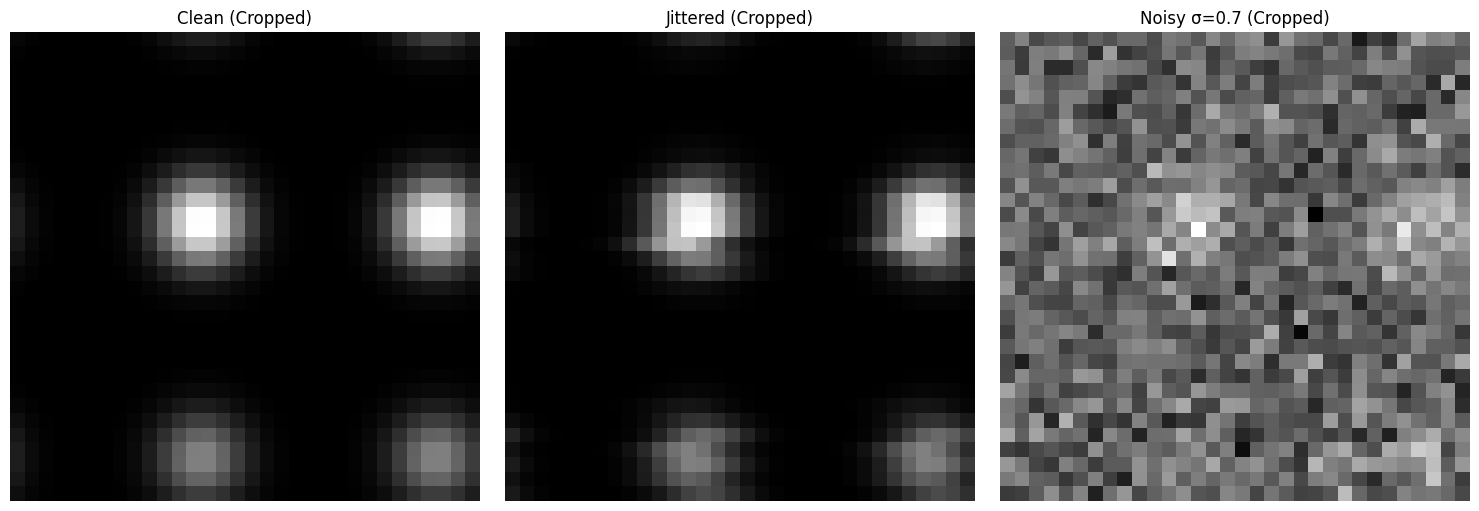

: 

In [ ]:
# Select a region of interest
h, w = clean_image.shape[:2] if len(clean_image.shape) > 1 else clean_image.shape
crop_size = min(256, h//4, w//4)
y_start, x_start = h//3, w//3

clean_crop = clean_image[y_start:y_start+crop_size, x_start:x_start+crop_size]
jittered_crop = jittered_image[y_start:y_start+crop_size, x_start:x_start+crop_size]
noisy_crop = noisy_image[y_start:y_start+crop_size, x_start:x_start+crop_size]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(clean_crop, cmap='gray')
axes[0].set_title('Clean (Cropped)')
axes[0].axis('off')

axes[1].imshow(jittered_crop, cmap='gray')
axes[1].set_title('Jittered (Cropped)')
axes[1].axis('off')

axes[2].imshow(noisy_crop, cmap='gray')
axes[2].set_title(f'Noisy σ={target_noise_level} (Cropped)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Summary

Data preparation complete!

**Files created:**
- `dataset01_clean.tif` - Ground truth (for evaluation only)
- `dataset01_signal.tif` - Jittered image (signal for noise calibration)
- `dataset01_noisy.tif` - Noisy image σ=0.7 (observation for calibration & training)

**Calibration Strategy:**
- Signal (s): `jittered_image.tif` 
- Observation (x): `noisy_image_...Gaussian_0.7.tif`
- This gives us P(x|s) for the specific noise level σ=0.7

**Next step:** Run `1_CreateNoiseModel_Calibration.ipynb`